In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler

# MAIN VERSION

In [2]:
# Read data
df = pd.read_excel("data/riskindicators_table.xlsx", sheet_name='Clean_Index_Main')
df['Risk Category'] = df['Risk Category'].ffill()
df = df.melt(id_vars=['Risk Category', 'Risk ID','Risk Indicator'], var_name='Company', value_name='Value')
df['Risk ID'] = df['Risk ID'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Risk Category   130 non-null    object 
 1   Risk ID         130 non-null    object 
 2   Risk Indicator  130 non-null    object 
 3   Company         130 non-null    object 
 4   Value           126 non-null    float64
dtypes: float64(1), object(4)
memory usage: 5.2+ KB


In [3]:
list_reversed_indicators = ['1.02', '1.03', 
                            '2.01', '2.02', '2.03', '2.05', '2.06', '2.07', '2.08', '2.09', '2.10',
                            '3.01', '3.02', '3.03']

In [4]:
# Define a custom scaling function for boolean values and edge cases
def safe_minmax_scale(group):
    # Check if the group is constant (all 0s or all 1s)
    if group.nunique() == 1:
        # Boolean edge case: Map 0 → 0, 1 → 100
        return group * 100
    else:
        # Standard MinMax scaling (0→0, 1→100)
        scaled = MinMaxScaler().fit_transform(group.values.reshape(-1, 1)).flatten() * 100
        return scaled

# Apply the scaling
df['Standardized Value'] = (
    df.groupby(['Risk Category', 'Risk Indicator'])['Value']
    .transform(safe_minmax_scale)
)

In [5]:
# Define a mask for rows to reverse
mask = df['Risk ID'].isin(list_reversed_indicators)

# For reversed rows, invert 0 ↔ 100 and handle constants
df.loc[mask, 'Standardized Value'] = (
    100 - df.loc[mask, 'Standardized Value']
)

In [6]:
df[df.isna().any(axis=1)]

,Risk Category,Risk ID,Risk Indicator,Company,Value,Standardized Value
78,1. Hypercompetitive behavior,1.01,Valuation growth (%),x.AI,NaN,NaN
80,1. Hypercompetitive behavior,1.03,Acceleration (yoy change in model updates freq...,x.AI,NaN,NaN
82,1. Hypercompetitive behavior,1.05,"Acquisitions - annual, cost",x.AI,NaN,NaN
85,1. Hypercompetitive behavior,1.08,"Revenue growth rate (YoY, %)",x.AI,NaN,NaN


In [7]:
min_value = df['Standardized Value'].min()
max_value = df['Standardized Value'].max()

print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")

Minimum value: -2.842170943040401e-14
Maximum value: 100.0


In [8]:
df.to_csv("data/riskindicators_table_std.csv", index=False)

In [9]:
# Aggregate the data by 'Company' and 'Risk Category'
risk_category_df = df.groupby(['Risk Category', 'Company']).agg({
    'Standardized Value': 'mean'
}).reset_index()

risk_category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Risk Category       20 non-null     object 
 1   Company             20 non-null     object 
 2   Standardized Value  20 non-null     float64
dtypes: float64(1), object(2)
memory usage: 612.0+ bytes


In [10]:
risk_category_df

,Risk Category,Company,Standardized Value
0,1. Hypercompetitive behavior,Anthropic,46.516382
1,1. Hypercompetitive behavior,Google DeepMind,19.947806
2,1. Hypercompetitive behavior,Meta AI,38.115195
3,1. Hypercompetitive behavior,OpenAI,62.305319
4,1. Hypercompetitive behavior,x.AI,26.666667
5,2. ​Lack of compliance and safety practices,Anthropic,26.023916
6,2. ​Lack of compliance and safety practices,Google DeepMind,54.993501
7,2. ​Lack of compliance and safety practices,Meta AI,69.017184
8,2. ​Lack of compliance and safety practices,OpenAI,51.424256
9,2. ​Lack of compliance and safety practices,x.AI,67.446939


In [11]:
risk_category_df.to_csv("data/risk_category_std.csv", index=False)

In [12]:
# Aggregate the data by 'Company'
risk_company_df = risk_category_df.groupby(['Company']).agg({
    'Standardized Value': 'mean'
}).reset_index()
risk_company_df = risk_company_df.sort_values(by='Standardized Value', ascending=True).reset_index(drop=True)
risk_company_df

,Company,Standardized Value
0,Anthropic,26.815630
1,Google DeepMind,32.401001
2,x.AI,52.595862
3,Meta AI,56.941825
4,OpenAI,61.765727


In [13]:
risk_company_df.to_csv("data/risk_company_std.csv", index=False)

In [14]:
# Sort the DataFrame by 'Standardized Value' in descending order
sorted_risk_company_df = risk_company_df.sort_values(by='Standardized Value', ascending=False)

# Create a table
table = go.Figure(data=[go.Table(
    header=dict(values=['Company', 'Risk Index'],
                fill_color='#009edb',
                font=dict(color='#ffffff'),
                align='center'),
    cells=dict(values=[sorted_risk_company_df['Company'], sorted_risk_company_df['Standardized Value'].map('{:.2f}'.format)],
               fill_color='#e4effb',
               font=dict(color='#454545'),
               align='center'))
])

# Update the layout
table.update_layout(
    autosize=True,
    width=500,
    height=200,
    margin=dict(l=10, r=10, t=40, b=0)
)

# Show the table
table.show()

In [15]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Pivot the DataFrame to get companies as rows and risk categories as columns
pivot_df = risk_category_df.pivot(index="Company", columns="Risk Category", values="Standardized Value")

# Rename columns to shorter names for better display
pivot_df.columns = [
    "1. Hypercompetitive Behaviour",
    "2. Lack of Compliance & Safety Practices",
    "3. Lack of Commitment to Emerging Standards",
    "4. Incidents"
]

# Calculate aggregate score (mean of all risk categories)
pivot_df["Aggregate Score"] = pivot_df.mean(axis=1)

# Reset index to have Company as a column
result_df = pivot_df.reset_index()

# Sort by aggregate score from highest to lowest
result_df = result_df.sort_values("Aggregate Score", ascending=False)

# Format all numeric columns to 2 decimal places
for col in result_df.columns:
    if col != "Company":
        result_df[col] = result_df[col].map('{:.2f}'.format)

# Create a Plotly table
table = go.Figure(data=[go.Table(
    header=dict(
        values=list(result_df.columns),
        fill_color='#009edb',
        font=dict(color='#ffffff'),
        align='center'
    ),
    cells=dict(
        values=[result_df[col] for col in result_df.columns],
        fill_color='#e4effb',
        font=dict(color='#454545'),
        align='center'
    )
)])

# Update the layout
table.update_layout(
    autosize=False,
    width=800,
    height=300,
    margin=dict(l=10, r=10, t=40, b=0)
)

# Show the table
table.show()

# Include all columns except "Company" for the heatmap
risk_categories = result_df.columns[1:]  # Includes Aggregate Score

heatmap = go.Figure(data=go.Heatmap(
    z=result_df[risk_categories].values,  # Include all risk categories & Aggregate Score
    x=risk_categories,  # Column names as x-axis labels
    y=result_df["Company"],  # Company names as y-axis labels
    colorscale='Reds',
    hoverongaps=False
))

heatmap.update_layout(
    title='Risk Component Score by Company (Higher Values = Higher Risk)',
    xaxis_title='Risk Component',
    yaxis_title='Company',
    width=900,
    height=500
)

# Show the heatmap
heatmap.show()

In [16]:
# Create gauge charts for each company horizontally
fig = make_subplots(
    rows=1, cols=len(risk_company_df),
    horizontal_spacing=0.05,
    # subplot_titles=risk_company_df['Company'].tolist(),
    specs=[[{'type': 'domain'} for _ in range(len(risk_company_df))]]
)

for i, row in risk_company_df.iterrows():
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=row['Standardized Value'],
            title={'text': f"{row['Company']}"},
            gauge={
                'axis': {'range': [0, 100]},
                'bar': {'color': "whitesmoke"},
                'steps': [
                    {'range': [0, 33], 'color': "#008450"},
                    {'range': [33, 66], 'color': "#EFB700"},
                    {'range': [66, 100], 'color': "#B81D13"}
                ],
                'threshold': {
                    'line': {'color': "whitesmoke", 'width': 5},
                    'thickness': 0.69,
                    'value': row['Standardized Value']
                },
                'bordercolor':'white',


            }
        ),
        row=1, col=i+1
    )

fig.update_layout(
    width=300 * len(risk_company_df),
    height=300,
    showlegend=False,
    title="Competitive Dynamic Risk Scores",
    font=dict(color='#454545'),
)

fig.show()

In [17]:
# Define a color map for each company
color_map = {
    'Anthropic': '#da7756',
    'Google DeepMind': '#4285F4', #4285F4 022c61
    'Meta AI': '#34b3f0', #34b3f0 1877F2
    'OpenAI': '#00A67E',
    'x.AI': '#000000'
}

In [18]:
# Create a horizontal bar chart
fig = go.Figure(data=[
    go.Bar(
        name='Standardized Value', 
        x=risk_company_df['Standardized Value'], 
        y=risk_company_df['Company'], 
        orientation='h',
        text=risk_company_df.index + 1,  # Add rank as text
        textposition='auto',
        marker=dict(color=[color_map[company] for company in risk_company_df['Company']])  # Set the bar color using color_map
    )
])

# Update the layout to remove x-axis and show y-axis with company names
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=True, tickmode='array', tickvals=risk_company_df.index, ticktext=risk_company_df['Company']),
    template='plotly_white',
    font=dict(color='#454545')  # Set the text color to textColor
)

fig.show()

In [19]:
# Create a list of unique risk categories
companies = risk_category_df['Company'].unique()
categories = risk_category_df['Risk Category'].unique()

# Create a radar chart
fig = go.Figure()

# Add a trace for each company
for company in companies:
    company_data = risk_category_df[risk_category_df['Company'] == company]
    fig.add_trace(go.Scatterpolar(
        r=company_data['Standardized Value'],
        theta=company_data['Risk Category'],
        connectgaps=True,
        fill='toself',
        name=company,
        line=dict(color=color_map[company])
    ))

# Update the layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100]
        )
    ),
    showlegend=True,
    title="Risk Index based on Category",
    font=dict(color='#454545'),
    plot_bgcolor='#e4effb'
)

fig.show()

In [20]:
# Create a subplot with 1 row and multiple columns (one for each company)
fig = make_subplots(
    rows=1, 
    cols=len(companies), 
    subplot_titles=[f"{company}" for company in companies], 
    specs=[[{'type': 'polar'}] * len(companies)]
)

# Add a trace for each company in its respective subplot
for i, company in enumerate(companies):
    company_data = risk_category_df[risk_category_df['Company'] == company]
    company_data = company_data.replace({
        'Risk Category': {
            "1. Hypercompetitive behavior": "Hypercompetitive",
            "2. ​Lack of compliance and safety practices": "Unsafety",
            "3. Lack of commitment to emerging standards": "Lack of Commitment",
            "4. Incidents": "Incidents"
        }
    })
    fig.add_trace(go.Scatterpolar(
        r=company_data['Standardized Value'],
        theta=company_data['Risk Category'],
        connectgaps=True,
        fill='toself',
        name=company,
        line=dict(color=color_map[company])
    ), row=1, col=i+1)

# Adjust the position of the subplot titles
for annotation in fig['layout']['annotations']:
    annotation['y'] += 0.1  

# Update the layout
for j in range(1, len(companies) + 1):
    fig.update_layout(**{f'polar{j}': dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100]
        ),
        angularaxis=dict(
            rotation=90
        ))
    })

fig.update_layout(
    width=3500,  # Adjust width as needed
    showlegend=False,
    # title="Risk Index based on Category for Each Company"
)

fig.show()


In [21]:
# Define a color map for each company
# company_colors = {
#     "Anthropic": "orange",
#     "Google DeepMind": "blue",
#     "Meta AI": "lightblue",
#     "OpenAI": "darkgreen",
#     "xAI": "black"
# }

# Create individual radar charts for each company
for company in companies:
    company_data = risk_category_df[risk_category_df['Company'] == company]
    company_data = company_data.replace({
        'Risk Category': {
            "1. Hypercompetitive behavior": "Hypercompetitive",
            "2. ​Lack of compliance and safety practices": "Unsafety",
            "3. Lack of commitment to emerging standards": "Lack of Commitment",
            "4. Incidents": "Incidents"
        }
    })
    
    fig = go.Figure()
    fig.add_trace(go.Scatterpolar(
        r=company_data['Standardized Value'],
        theta=company_data['Risk Category'],
        connectgaps=True,
        fill='toself',
        name=company,
        line=dict(color=color_map[company])
    ))

    # Update the layout
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 100]
            ),
            angularaxis=dict(
                rotation=90
            )
        ),
        showlegend=False,
        title={
            'text': f"{company}",
            'x': 0.5,
            'xanchor': 'center'
        }
    )

    fig.show()


In [22]:
# from plotly.subplots import make_subplots

# # Create a subplot with 5 rows (one for each company) and 1 column
# fig = make_subplots(
#     rows=len(companies), 
#     cols=1, 
#     subplot_titles=[f"{company}" for company in companies], 
#     specs=[[{'type': 'polar'}]] * len(companies)
# )

# # Adjust the position of the subplot titles
# for annotation in fig['layout']['annotations']:
#     annotation['y'] += 0.02

# # Add a trace for each company in its respective subplot
# for i, company in enumerate(companies):
#     company_data = risk_category_df[risk_category_df['Company'] == company]
#     fig.add_trace(go.Scatterpolar(
#         r=company_data['Standardized Value'],
#         theta=company_data['Risk Category'],
#         connectgaps=True,
#         fill='toself',
#         name=company
#     ), row=i+1, col=1)

# # Update the layout
# for j in range(1, len(companies) + 1):
#     fig.update_layout(**{f'polar{j}': dict(
#         radialaxis=dict(
#             visible=True,
#             range=[0, 400]
#         ),
#         angularaxis=dict(
#             rotation=90
#         ))
#     })

# fig.update_layout(
#     height=1920,  # Adjust height as needed
#     showlegend=True,
#     # title="Risk Index based on Category for Each Company"
# )

# fig.show()


In [23]:
# Create a radar chart for each category
for category in categories:
    category_data = df[df['Risk Category'] == category]
    
    fig = go.Figure()
    
    # Add a trace for each company
    for company in companies:
        company_data = category_data[category_data['Company'] == company]
        fig.add_trace(go.Scatterpolargl(
            r=company_data['Standardized Value'],
            theta=company_data['Risk ID'],
            connectgaps=True,
            fill='toself',
            name=company,
            line=dict(color=color_map[company])
        ))

    # Update the layout to move the legend to the bottom
    fig.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.3,
            xanchor="center",
            x=0.5
        )
    )
    
    # Add annotations for Risk ID and Risk Indicator
    annotations = []
    for risk_id, risk_indicator in zip(category_data['Risk ID'].unique(), category_data['Risk Indicator'].unique()):
        annotations.append(f"{risk_id}: {risk_indicator}")
    
    # Update the layout
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 100]
            )),
        showlegend=True,
        title=f"Radar Chart for {category}",
        annotations=[dict(
            x=1.0,
            y=1.1,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<br>".join(annotations),
            align="left"
        )]
    )
    
    fig.show()

In [24]:
# Create a radar chart for each category
for company in companies:
    company_data = df[df['Company'] == company]
    
    fig = make_subplots(
        rows=2, 
        cols=2, 
        subplot_titles=[f"{category}" for category in categories],
        specs=[[{'type': 'polar'}, {'type': 'polar'}], [{'type': 'polar'}, {'type': 'polar'}]],
    )

    # Add a trace for each category in its respective subplot
    for i, category in enumerate(categories):
        category_data = df[df['Risk Category'] == category]
        row = i // 2 + 1
        col = i % 2 + 1
        fig.add_trace(go.Scatterpolar(
            r=category_data[category_data['Company'] == company]['Standardized Value'],
            theta=category_data[category_data['Company'] == company]['Risk ID'],
            connectgaps=True,
            fill='toself',
            name=category,
            line=dict(color=color_map[company])
        ), row=row, col=col)

    # Adjust the position of the subplot titles
    for annotation in fig['layout']['annotations']:
        annotation['y'] += 0.05
    
    fig.update_layout(
        height=800,
        width=800,
        showlegend=False,
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 100]
            ),
            angularaxis=dict(
                rotation=90
            )
        ),
        polar2=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 100]
            ),
            angularaxis=dict(
                rotation=90
            )
        ),
        polar3=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 100]
            ),
            angularaxis=dict(
                rotation=90
            )
        ),
        polar4=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 100]
            ),
            angularaxis=dict(
                rotation=90
            )
        )
    )
    
    fig.show()


## Regressions

### Only components

In [25]:
import statsmodels.api as sm

# Pivot the data so that each company has its own row and each risk category becomes a column.
df_pivot = risk_category_df.pivot(index='Company', columns='Risk Category', values='Standardized Value')

# Rename the columns for clarity. The mapping is:
# "1. Competitive behavior/practice"  -> "Competitive"
# "2. ​Compliance and Safety Practices" -> "Safety"
# "3. Commitment to emerging standards" -> "Commitment"
# "4. Incidents"                        -> "Incidents"
rename_map = {
    "1. Hypercompetitive behavior": "Hypercompetitive",
            "2. ​Lack of compliance and safety practices": "Unsafety",
            "3. Lack of commitment to emerging standards": "Lack of Commitment",
            "4. Incidents": "Incidents"
}
df_pivot = df_pivot.rename(columns=rename_map)

# Display the pivoted data (optional)
print(df_pivot)

# Define the dependent variable (y) and independent variables (X)
y = df_pivot['Incidents']
X = df_pivot[['Hypercompetitive', 'Unsafety', 'Lack of Commitment']]

# Add a constant term to the independent variables (the intercept)
X = sm.add_constant(X)

# Run the OLS regression
model = sm.OLS(y, X).fit(cov_type='HC3')

# Print the summary which includes coefficients, standard errors, and p-values.
print(model.summary())


Risk Category    Hypercompetitive   Unsafety  Lack of Commitment   Incidents
Company                                                                     
Anthropic               46.516382  26.023916           33.333333    1.388889
Google DeepMind         19.947806  54.993501           33.333333   21.329365
Meta AI                 38.115195  69.017184          100.000000   20.634921
OpenAI                  62.305319  51.424256           33.333333  100.000000
x.AI                    26.666667  67.446939          100.000000   16.269841
                            OLS Regression Results                            
Dep. Variable:              Incidents   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                    0.4226
Date:                Mon, 03 Mar 2025   Prob (F-statistic):              0.778
Time:                        19:04:54   Log-Likelihood:           

c:\Users\madegde\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 5 samples were given.



In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

              feature        VIF
0               const  33.261062
1    Hypercompetitive   1.201569
2            Unsafety   2.530417
3  Lack of Commitment   2.400298


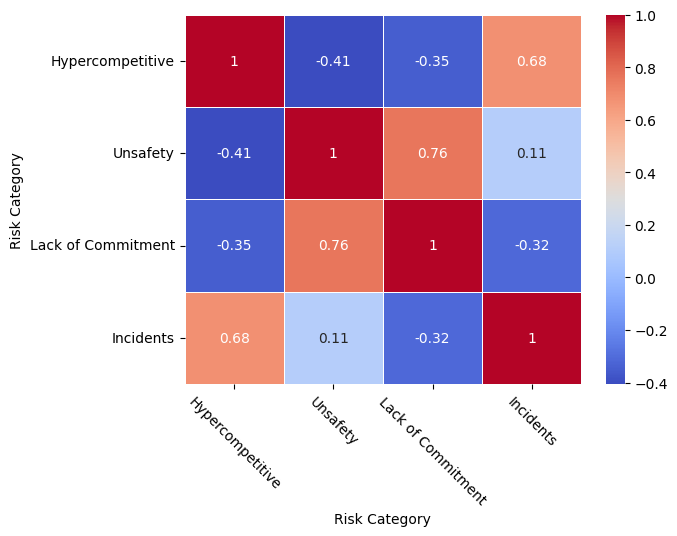

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df_pivot.corr()

# Plot the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=.5)

# Rotate the x-axis text
plt.xticks(rotation=-45)

plt.show()

# RANK VERSION

In [28]:
rank_df = df.copy()
rank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Risk Category       130 non-null    object 
 1   Risk ID             130 non-null    object 
 2   Risk Indicator      130 non-null    object 
 3   Company             130 non-null    object 
 4   Value               126 non-null    float64
 5   Standardized Value  126 non-null    float64
dtypes: float64(2), object(4)
memory usage: 6.2+ KB


In [29]:
rank_df['Rank'] = rank_df.groupby(['Risk Category', 'Risk Indicator'])['Standardized Value'].rank(ascending=True, method='min')
rank_df

,Risk Category,Risk ID,Risk Indicator,Company,Value,Standardized Value,Rank
0,1. Hypercompetitive behavior,1.01,Valuation growth (%),Google DeepMind,0.356217,0.000000,1.0
1,1. Hypercompetitive behavior,1.02,Market share (revenue),Google DeepMind,0.070000,84.188371,2.0
2,1. Hypercompetitive behavior,1.03,Acceleration (yoy change in model updates freq...,Google DeepMind,3.892183,0.000000,1.0
3,1. Hypercompetitive behavior,1.04,"Acquisitions - annual, count",Google DeepMind,0.000000,0.000000,1.0
4,1. Hypercompetitive behavior,1.05,"Acquisitions - annual, cost",Google DeepMind,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...
125,3. Lack of commitment to emerging standards,3.03,Endorsement of UN Global Digital Compact,OpenAI,0.000000,100.000000,1.0
126,4. Incidents,4.01,AI-related incidents,OpenAI,30.000000,100.000000,5.0
127,4. Incidents,4.02,Cybersecurity incidents (related to security/s...,OpenAI,2.000000,100.000000,5.0
128,4. Incidents,4.03,Litigation Frequency as Defendant,OpenAI,18.000000,100.000000,5.0


In [30]:
rank_df.to_csv("data/riskindicators_table_rank.csv", index=False)

In [31]:
# Aggregate the data by 'Company' and 'Risk Category'
rank_cat_df = rank_df.groupby(['Risk Category', 'Company']).agg({'Rank': 'sum'}).reset_index()
rank_cat_df['Rank'] = rank_cat_df.groupby('Risk Category')['Rank'].rank(ascending=True, method='min')
rank_cat_df

,Risk Category,Company,Rank
0,1. Hypercompetitive behavior,Anthropic,4.0
1,1. Hypercompetitive behavior,Google DeepMind,2.0
2,1. Hypercompetitive behavior,Meta AI,3.0
3,1. Hypercompetitive behavior,OpenAI,5.0
4,1. Hypercompetitive behavior,x.AI,1.0
5,2. ​Lack of compliance and safety practices,Anthropic,1.0
6,2. ​Lack of compliance and safety practices,Google DeepMind,3.0
7,2. ​Lack of compliance and safety practices,Meta AI,4.0
8,2. ​Lack of compliance and safety practices,OpenAI,2.0
9,2. ​Lack of compliance and safety practices,x.AI,5.0


In [32]:
rank_cat_df.to_csv("data/risk_category_rank.csv", index=False)

In [33]:
# Aggregate the data by 'Company'
rank_company_df = rank_cat_df.groupby(['Company']).agg({'Rank': 'sum'}).reset_index()
rank_company_df['Rank'] = rank_company_df['Rank'].rank(ascending=True, method='min')
rank_company_df = rank_company_df.sort_values(by='Rank', ascending=True).reset_index(drop=True)
rank_company_df


,Company,Rank
0,Anthropic,1.0
1,Google DeepMind,2.0
2,x.AI,3.0
3,OpenAI,4.0
4,Meta AI,5.0


In [34]:
rank_company_df.to_csv("data/risk_company_rank.csv", index=False)

In [35]:
# Create a horizontal bar chart
fig = go.Figure(data=[
    go.Bar(
        name='Rank', 
        x=rank_company_df['Rank'], 
        y=rank_company_df['Company'], 
        orientation='h',
        text=rank_company_df.index + 1,  # Add rank as text
        textposition='auto',
        marker=dict(color=[color_map[company] for company in risk_company_df['Company']])
    )
])

# Update the layout to remove x-axis and show y-axis with company names
fig.update_layout(
    title='Rank by Company',
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=True, tickmode='array', tickvals=rank_company_df.index, ticktext=rank_company_df['Company']),
    template='plotly_white',
    font=dict(color='#454545'),
    # plot_bgcolor='#e4effb'
)

fig.show()

In [36]:
# Create a list of unique risk categories
rank_cat = rank_cat_df['Risk Category'].unique()
rank_comp = rank_cat_df['Company'].unique()

# Create a radar chart
fig = go.Figure()

# Add a trace for each company
for company in rank_comp:
    company_data = rank_cat_df[rank_cat_df['Company'] == company]
    fig.add_trace(go.Scatterpolar(
        r=company_data['Rank'],
        theta=categories,
        connectgaps=True,
        fill='toself',
        name=company,
        line=dict(color=color_map[company])
    ))

# Update the layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
        angularaxis=dict(
            rotation=90
        )
    ),
    showlegend=True,
    title="Risk Rank based on Category",
    font=dict(color='#454545'),
    plot_bgcolor='#e4effb'
)

fig.show()

In [37]:
# Create a subplot with 1 row and multiple columns (one for each company)
fig = make_subplots(
    rows=1, 
    cols=len(rank_comp), 
    subplot_titles=[f"{company}" for company in rank_comp], 
    specs=[[{'type': 'polar'}] * len(rank_comp)]
)

# Add a trace for each company in its respective subplot
for i, company in enumerate(rank_comp):
    company_data = rank_cat_df[rank_cat_df['Company'] == company]
    company_data = company_data.replace({
        'Risk Category': {
            "1. Hypercompetitive behavior": "Hypercompetitive",
            "2. ​Lack of compliance and safety practices": "Unsafety",
            "3. Lack of commitment to emerging standards": "Lack of Commitment",
            "4. Incidents": "Incidents"
        }
    })
    fig.add_trace(go.Scatterpolar(
        r=company_data['Rank'],
        theta=company_data['Risk Category'],
        connectgaps=True,
        fill='toself',
        name=company,
        line=dict(color=color_map[company])
    ), row=1, col=i+1)

# Adjust the position of the subplot titles
for annotation in fig['layout']['annotations']:
    annotation['y'] += 0.1  

# Update the layout
for j in range(1, len(companies) + 1):
    fig.update_layout(**{f'polar{j}': dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
        angularaxis=dict(
            rotation=90
        ))
    })

fig.update_layout(
    width=2000,  # Adjust width as needed
    showlegend=False,
    # title="Risk Index based on Category for Each Company",
    font=dict(color='#454545'),
    plot_bgcolor='#e4effb'
)

fig.show()


In [38]:
# Create individual radar charts for each company
for company in rank_comp:
    company_data = rank_cat_df[rank_cat_df['Company'] == company]
    company_data = company_data.replace({
        'Risk Category': {
            "1. Hypercompetitive behavior": "Hypercompetitive",
            "2. ​Lack of compliance and safety practices": "Unsafety",
            "3. Lack of commitment to emerging standards": "Lack of Commitment",
            "4. Incidents": "Incidents"
        }
    })
    
    fig = go.Figure()
    fig.add_trace(go.Scatterpolar(
        r=company_data['Rank'],
        theta=company_data['Risk Category'],
        connectgaps=True,
        fill='toself',
        name=company,
        line=dict(color=color_map[company])
    ))

    # Update the layout
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 5]
            ),
            angularaxis=dict(
                rotation=90
            )
        ),
        showlegend=False,
        title={
            'text': f"{company}",
            'x': 0.5,
            'xanchor': 'center'
        },
        font=dict(color='#454545'),
        plot_bgcolor='#e4effb'
    )

    fig.show()


In [39]:
# Create a radar chart for each category
for category in categories:
    category_data = rank_df[rank_df['Risk Category'] == category]
    
    fig = go.Figure()
    
    # Add a trace for each company
    for company in companies:
        company_data = category_data[category_data['Company'] == company]
        fig.add_trace(go.Scatterpolargl(
            r=company_data['Rank'],
            theta=company_data['Risk ID'],
            connectgaps=True,
            fill='toself',
            name=company,
            line=dict(color=color_map[company])
        ))

    # Update the layout to move the legend to the bottom
    fig.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.3,
            xanchor="center",
            x=0.5
        )
    )
    
    # Add annotations for Risk ID and Risk Indicator
    annotations = []
    for risk_id, risk_indicator in zip(category_data['Risk ID'].unique(), category_data['Risk Indicator'].unique()):
        annotations.append(f"{risk_id}: {risk_indicator}")
    
    # Update the layout
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 5]),
        angularaxis=dict(
            rotation=90
        )),
        showlegend=True,
        title=f"Rank Chart for {category}",
        annotations=[dict(
            x=1.0,
            y=1.1,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<br>".join(annotations),
            align="left"
        )],
        font=dict(color='#454545'),
        plot_bgcolor='#e4effb'
    )
    
    fig.show()

# FULL VERSION

In [40]:
# Read data
data = pd.read_excel("data/riskindicators_table.xlsx", sheet_name='Clean_Index_Full')
data['Risk Category'] = data['Risk Category'].ffill()
data = data.melt(id_vars=['Risk Category', 'Risk ID','Risk Indicator'], var_name='Company', value_name='Value')
data['Risk ID'] = data['Risk ID'].astype(str)

# List of reversed indicators
list_reversed_indicators = ['1.02', '1.03', 
                            '2.01', '2.02', '2.03', '2.05', '2.06', '2.07', '2.08', '2.09', '2.10',
                            '3.01', '3.02', '3.03', '3.04',
                            ]

# Apply the scaling
data['Standardized Value'] = (
    data.groupby(['Risk Category', 'Risk Indicator'])['Value']
    .transform(safe_minmax_scale)
)

# Define a mask for rows to reverse
mask = data['Risk ID'].isin(list_reversed_indicators)

# For reversed rows, invert 0 ↔ 100 and handle constants
data.loc[mask, 'Standardized Value'] = (
    100 - data.loc[mask, 'Standardized Value']
)

# Save to CSV
data.to_csv("data/riskindicators_table_full.csv", index=False)

In [41]:
# Aggregate the data by 'Company' and 'Risk Category'
risk_category_data = data.groupby(['Risk Category', 'Company']).agg({
    'Standardized Value': 'mean'
}).reset_index()

# Save to CSV
risk_category_data.to_csv("data/risk_category_full.csv", index=False)

In [42]:
# Aggregate the data by 'Company'
risk_company_data = risk_category_data.groupby(['Company']).agg({
    'Standardized Value': 'mean'
}).reset_index()
risk_company_data = risk_company_data.sort_values(by='Standardized Value', ascending=True).reset_index(drop=True)

# Save to CSV
risk_company_data.to_csv("data/risk_company_full.csv", index=False)

In [43]:
import statsmodels.api as sm

# Pivot the data so that each company has its own row and each risk category becomes a column.
df_pivot = risk_category_data.pivot(index='Company', columns='Risk Category', values='Standardized Value')

# Rename the columns for clarity. The mapping is:
# "1. Competitive behavior/practice"  -> "Competitive"
# "2. ​Compliance and Safety Practices" -> "Safety"
# "3. Commitment to emerging standards" -> "Commitment"
# "4. Incidents"                        -> "Incidents"
rename_map = {
    "1. Hypercompetitive behavior": "Hypercompetitive",
            "2. ​Lack of compliance and safety practices": "Unsafety",
            "3. Lack of commitment to emerging standards": "Lack of Commitment",
            "4. Incidents": "Incidents"
}
df_pivot = df_pivot.rename(columns=rename_map)

# Display the pivoted data (optional)
print(df_pivot)

# Define the dependent variable (y) and independent variables (X)
y = df_pivot['Incidents']
X = df_pivot[['Hypercompetitive', 'Unsafety', 'Lack of Commitment']]

# Add a constant term to the independent variables (the intercept)
X = sm.add_constant(X)

# Run the OLS regression
model = sm.OLS(y, X).fit(cov_type='HC3')

# Print the summary which includes coefficients, standard errors, and p-values.
print(model.summary())


Risk Category    Hypercompetitive   Unsafety  Lack of Commitment   Incidents
Company                                                                     
Anthropic               46.516382  26.023916           25.000000    1.111111
Google DeepMind         19.947806  54.993501           27.805504   17.063492
Meta AI                 38.115195  69.017184           86.968638   16.507937
OpenAI                  62.305319  51.424256           29.543715  100.000000
x.AI                    26.666667  67.446939          100.000000   13.015873
                            OLS Regression Results                            
Dep. Variable:              Incidents   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                    0.3041
Date:                Mon, 03 Mar 2025   Prob (F-statistic):              0.833
Time:                        19:05:16   Log-Likelihood:           

c:\Users\madegde\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 5 samples were given.



<Axes: xlabel='Risk Category', ylabel='Risk Category'>

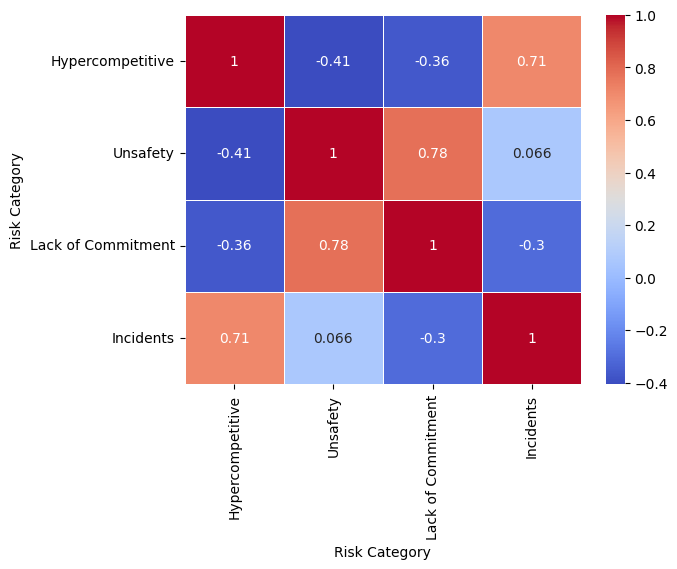

In [44]:
import seaborn as sns

# Compute the correlation matrix
corr = df_pivot.corr()

# Plot the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=.5)